### Classification problem ###
Building a classifier which can distinguish cats from dogs.

In [0]:
# import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

### Download the dataset ### 

We are using the 2000 images dataset provided by google colab for this problem.

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-09-24 23:41:55--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 2a00:1450:4013:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  83.4MB/s    in 0.8s    

2019-09-24 23:41:57 (83.4 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
!ls /tmp/cats_and_dogs_filtered

In [0]:
!ls /tmp/cats_and_dogs_filtered/train

In [0]:
!ls /tmp/cats_and_dogs_filtered/train/dogs

In [0]:
train_cat = os.listdir("/tmp/cats_and_dogs_filtered/train/cats")
train_dog = os.listdir("/tmp/cats_and_dogs_filtered/train/dogs")
test_cat = os.listdir("/tmp/cats_and_dogs_filtered/validation/cats")
test_dog = os.listdir("/tmp/cats_and_dogs_filtered/validation/dogs")

In [5]:
print("Length of training dataset: ", len(train_cat)+len(train_dog))
print("Length of validation dataset: ", len(test_cat)+len(test_dog))

Length of training dataset:  2000
Length of validation dataset:  1000


### Explore the dataset ###

(499, 366, 3)
Max:  255 Min:  2
(346, 258, 3)
Max:  255 Min:  0
(477, 499, 3)
Max:  255 Min:  0
(377, 499, 3)
Max:  255 Min:  0


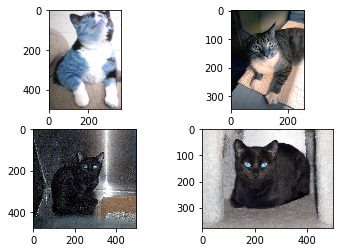

In [6]:
# Plot the images
for i in range(4):
  plt.subplot(220 + 1 + i)
  filename = os.path.join("/tmp/cats_and_dogs_filtered/train/cats", train_cat[i])
  image = cv2.imread(filename)
  print(image.shape)
  print("Max: ", np.max(image), "Min: ", np.min(image))
  plt.imshow(image)

(174, 141, 3)
Max:  255 Min:  0
(136, 117, 3)
Max:  249 Min:  0
(499, 400, 3)
Max:  255 Min:  0
(306, 362, 3)
Max:  255 Min:  0


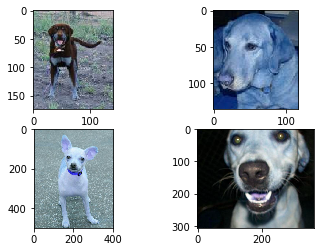

In [7]:
# Plot the images
for i in range(4):
  plt.subplot(220 + 1 + i)
  filename = os.path.join("/tmp/cats_and_dogs_filtered/train/dogs", train_dog[i])
  image = cv2.imread(filename)
  print(image.shape)
  print("Max: ", np.max(image), "Min: ", np.min(image))
  plt.imshow(image)

### Network parameters ###

In [0]:
image_size= 150 # data input
labels_size = 1 # labels

### Preprocess the data ###
We observe that the images are of different sizes. To process the images from a neural network, let's reshape these images to the same size.

In [0]:
def prepare_data(base_direc, img_paths):
  '''
    Parameters:
    base_direc: Base directory path.
    img_paths: list of image names
  '''
  image_list, label_list = [], []
  print(img_paths)
  for impath in img_paths:
    if impath.startswith('cat'):
      label = 1
    else:
      label= 0
    img_path = os.path.join(base_direc, impath)
    image = cv2.imread(img_path)
    image_resized = cv2.resize(image, (image_size, image_size))
    image_list.append(image_resized)
    label_list.append(np.array(label).reshape(1))
  return image_list, label_list

In [0]:
# Prepare training data
train_data_cats, train_labels_cats = prepare_data("/tmp/cats_and_dogs_filtered/train/cats", train_cat)
train_data_dogs, train_labels_dogs = prepare_data("/tmp/cats_and_dogs_filtered/train/dogs", train_dog)

In [0]:
test_data_cats, test_labels_cats = prepare_data("/tmp/cats_and_dogs_filtered/validation/cats", test_cat)
test_data_dogs, test_labels_dogs = prepare_data("/tmp/cats_and_dogs_filtered/validation/dogs", test_dog)

In [0]:
# Plot the images
i=100
image = test_data_dogs[i]
print(test_labels_dogs[i])
plt.imshow(image)

In [0]:
train_images_un = np.array(train_data_dogs + train_data_cats)
train_labels_un = np.array(train_labels_dogs + train_labels_cats)
test_images_un = np.array(test_data_dogs + test_data_cats)
test_labels_un = np.array(test_labels_dogs + test_labels_cats)

### Shuffle the dataset randomly ###
If we feed the data in the order that all dog images are fed first, and then the cat images, the network does not learn and the weights become biased towards predicting one class.  
Solution: Randomly shuffle the dataset without breaking association between input data and output labels.

In [0]:
# randomly shuffle the dataset.
train_perm = np.random.permutation(len(train_images_un))
train_images = train_images_un[train_perm]
train_labels = train_labels_un[train_perm]

test_perm = np.random.permutation(len(test_images_un))
test_images = test_images_un[test_perm]
test_labels = test_labels_un[test_perm]

### Defining Hyperparameters ###

In [0]:
steps_num = 50 # training epochs - number of times you want to repeat the training on the same dataset.
learning_rate = 0.001 # learning rate/step size - controls how much we are adjusting the weights of the network w.r.t. to the loss gradients.
batch_size = 100 # chooses the images in batches 

It is recommended to use a batch size in the power of 2, since the number of physical processor is often a power of 2.
Make sure that your machine has sufficient RAM to handle the specific batch size.

### Setup the architecture ###

In [0]:
# defining placeholders
training_data = tf.placeholder(tf.float32, [None, image_size, image_size, 3], name="training_data") # input placeholder
labels = tf.placeholder(tf.float32, [None, labels_size], name="labels") # output data

The first dimension is None. It tells the placeholder that it will receive this dimension when you feed in the data to it. 

### Wrapper functions ###

Checkout:

tf.nn.conv2d https://www.tensorflow.org/api_docs/python/tf/nn/conv2d

tf.nn.max_pool https://www.tensorflow.org/api_docs/python/tf/nn/max_pool

In [0]:
# convolution layer + Relu
def conv2d(x, W, b, s):
  # stride in the first and last dimension is always 1. First dimension is the image number and the last dimension is for the input channel.
  # padding 'SAME' - to keep the dimension same.
  y = tf.nn.conv2d(x, W, strides=[1, s, s, 1], padding='SAME') 
  y = tf.nn.bias_add(y, b)
  y = tf.nn.relu(y)
  return y

# Max pooling layer
def maxpool2d(X, k):
  y = tf.nn.max_pool(X, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
  return y

### Weight and Bias Parameters ###

#### For conv layers: ####

A **weight variable** will be of the form: **(f, f, c, out_c)** - You apply out_c number of filters of size f X f across c channels.

The first and second parameter are the filter size, third parameter is the input number of channels, fourth parameter is the output number of channel of the layer.


#### For fully connected layers: ####

Since we will flatten the image before feeding into the fully connected layers. The weights of the FC layers are of the form - **(input_dim, output_dim)**


A **bias variable** shape is equivalent to the number of output channels of that layer.


In [0]:
weights = {
   # Initialize weights here.
}

In [0]:
biases = {
    # Initialize the biases here.
}

### Model Architecture ###

In [0]:
def model(X, weights, biases):
  # Model Architecture
  return output

In [0]:
predict = model(training_data, weights, biases)

# tf.reduce_mean calculates the mean over all the batches to get the single loss value.
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=predict, labels=labels))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

### Evaluating the model predictions ###

To learn more about the sigmoid activation: https://en.wikipedia.org/wiki/Sigmoid_function

In [0]:
prediction = tf.round(tf.math.sigmoid(predict))

correct_pred = tf.equal(prediction, labels)

# calculate the accuracy across the images and average them out.
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [0]:
# initialize the global variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)
  
  train_loss, test_loss, train_acc, test_acc = [], [], [], []
  
  for ep in range(steps_num):
    train_loss_ep, train_acc_ep = [], []
    for itr in range(len(train_images)//batch_size):
      batch_x = np.array(train_images[itr*batch_size:min((itr+1)*batch_size, len(train_images))])
      batch_y = np.array(train_labels[itr*batch_size:min((itr+1)*batch_size, len(train_images))])
    
      
      # run the optimizer, loss and accuracy
      opt = sess.run(optimizer, feed_dict={training_data: batch_x, labels: batch_y})
      
      _, loss_val, acc_val = sess.run([optimizer, loss, accuracy], feed_dict={training_data: batch_x, labels: batch_y})
        
      assert(not np.isnan(loss_val))
  
      train_loss_ep.append(loss_val)
      train_acc_ep.append(acc_val)
    
    # find the training loss and accuracy per epoch
    train_loss_per_epoch = np.mean(np.array(train_loss_ep))
    train_loss.append(train_loss_per_epoch)
    train_acc_per_epoch = np.mean(np.array(train_acc_ep))
    train_acc.append(train_acc_per_epoch)
    
    print("\nEpoch: {:0d} \t Training Loss: {:.3f}, Training Accuracy: {:.3f}".format(ep, train_loss_per_epoch, train_acc_per_epoch))
     
    # find testing loss and accuracy 
    test_loss_ep, test_acc_ep = sess.run([loss, accuracy], feed_dict={training_data: test_images, labels: test_labels})
    
    print("\nTesting Loss: {:.3f}, Testing Accuracy: {:.3f}".format(test_loss_ep, test_acc_ep))
    test_acc.append(test_acc_ep)
    test_loss.append(test_loss_ep)

### Visualize the loss and accuracy ###

In [0]:
# Visualize the loss.
plt.plot(range(len(train_loss)), train_loss, 'r', label="Training Loss")
plt.plot(range(len(test_loss)), test_loss, 'b', label="Testing Loss")
plt.title("Training vs Testing Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
# Visualize the accuracy.
plt.plot(range(len(train_acc)), train_acc, 'r', label="Training Accuracy")
plt.plot(range(len(test_acc)), test_acc, 'b', label="Testing Accuracy")
plt.title("Training vs Testing Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()